## ***Todositos***

1 - ~~Implement changes for BPA (23)~~

2 - ~~Reply to Pavel (23)~~

3 - ~~Initiate a slide for RR presentation (23)~~

4 - ~~Complete data description slide (23)~~

5 - Collect all datasets in one dataframe (23)

6 - Do EDA, gap analysis (24)

7 - Write down an email to Ł, explain the data source found and give link to notebook (24)

In [245]:
library(tidyverse)
library(dplyr)
library("readxl")
install.packages("reshape2")
library(reshape2)

Warning message:
"package 'reshape2' is in use and will not be installed"


**Processing World Bank indicators**

In [246]:
# Read indicators from World Bank
wb_indicators_raw <- read_excel("Data\\WDI - WorldBank\\Indicators.xlsx", sheet = "Data")
# Melt dataset to put years to rows
wb_indicators_melted <- melt(wb_indicators_raw, id.vars = c("Country Name", "Country Code", "Series Code", "Series Name"), 
                  variable.name = "Year", value.name = "Value")
# Convert the 'Value' column to numeric, coerce errors
wb_indicators_melted$Value <- as.numeric(as.character(wb_indicators_melted$Value))
# Clean and convert the 'Year' column to numeric
wb_indicators_melted$Year <- gsub("\\[.*\\]", "", wb_indicators_melted$Year)
wb_indicators_melted$Year <- as.numeric(wb_indicators_melted$Year)
# Drop NAs
wb_indicators_long <- na.omit(wb_indicators_melted)
# Convert to wide format, representing each indicator as a column
wb_indicators_wide <- pivot_wider(wb_indicators_long, 
                          id_cols = c("Country Name", "Country Code", "Year"),  # List the columns you want to keep as base dimensions
                          names_from = "Series Code", 
                          values_from = "Value")
# Rename columns
wb_indicators_final <- wb_indicators_wide %>%
        rename(!!!setNames(c("Country Name", "Country Code", "Year"), c("country", "country_code", "year")))
# Sort dataset
wb_indicators_final <- wb_indicators_final %>% arrange (country, year)
# Check final dataset
print(dim(wb_indicators_final))
head(wb_indicators_final)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


[1] 13233    32


country,country_code,year,EN.URB.LCTY.UR.ZS,SP.POP.GROW,EN.POP.DNST,NY.GDP.PCAP.CD,SP.POP.TOTL,EN.ATM.CO2E.SF.ZS,EN.ATM.CO2E.LF.ZS,⋯,EG.USE.COMM.FO.ZS,NY.GDP.PCAP.KD.ZG,NV.SRV.TOTL.ZS,NV.IND.TOTL.ZS,NV.AGR.TOTL.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.KT,EN.ATM.GHGT.KT.CE,EG.FEC.RNEW.ZS,NY.ADJ.DPEM.GN.ZS
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,AFG,1973,38.65707,2.524421,17.74727,149.7441,11575305,19.01566,42.95302,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,1974,39.61917,2.513007,18.19892,181.5988,11869879,15.86998,40.15296,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,1975,40.65717,2.393287,18.63972,194.6690,12157386,18.79310,41.20690,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,1976,41.82373,2.179517,19.05044,205.6741,12425267,21.40221,44.46494,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,1977,43.06502,2.086951,19.45219,232.7787,12687301,18.86503,40.79755,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,1978,44.40577,1.963377,19.83788,255.0456,12938862,26.65535,43.29372,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


**Processing weather variables**

In [247]:
# Read weather datasets
precipitation_raw = read_csv("Data\\Weather\\GDL-Total-Yearly-Precipitation-data.csv", col_types = cols())
humidity_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Relative-Humidity-data.csv", col_types = cols())
avg_surface_temp_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Surface-Temperature-(ºC)-data.csv", col_types = cols())
# Common fuction to melt and clean weather datasets
clean_weather_datasets <- function (df, measure) {
    # Melt dataset to put years to rows
    df_melted <- melt(df, id.vars = c("Country", "Continent", "ISO_Code", "Level", "GDLCODE", "Region"), 
                    variable.name = "Year", value.name = "Value")
    # Convert the 'Value' column to numeric, coerce errors
    df_melted[measure] <- as.numeric(df_melted$Value)
    # Clean and convert the 'Year' column to numeric
    df_melted$Year <- as.numeric(as.character(df_melted$Year))
    # Drop NAs
    df_final <- na.omit(df_melted)
    # Drop unnecassary columns
    cols_to_drop <- c("Continent", "Level", "GDLCODE", "Region", "Value")
    df_final <- df_final %>% select(-one_of(cols_to_drop))
    # Rename columns
    df_final <- df_final %>%
        rename(!!!setNames(c("Country", "ISO_Code", "Year"), c("country", "country_code", "year")))
    # Return cleaned dataframe
    return (df_final)
    }
# Melt and clean weather datasets
precipitation_final <- clean_weather_datasets(precipitation_raw, "precipitation")
humidity_final <- clean_weather_datasets(humidity_raw, "humidity")
avg_surface_temp_final <- clean_weather_datasets(avg_surface_temp_raw, "avg_surface_temp")
# Check dimensions before join
print(paste0("precipitation_final: " ,dim(precipitation_final)[1], " rows"))
print(paste0("humidity_final: " ,dim(humidity_final)[1], " rows"))
print(paste0("avg_surface_temp_final: " ,dim(avg_surface_temp_final)[1], " rows"))
# Inner join precipitation, humidity and avg surface temperature datasets
weather_final <- inner_join(precipitation_final, humidity_final, by = c("country", "country_code", "year")) %>%
             inner_join(avg_surface_temp_final, by = c("country", "country_code", "year"))
# Check dimensions after inner join
print(paste0("weather_final: " ,dim(weather_final)[1], " rows"))
# Sort dataset
weather_final <- weather_final %>% arrange(country, year)
# Check dataset
print(dim(weather_final))
head(weather_final)

[1] "precipitation_final: 6666 rows"
[1] "humidity_final: 6666 rows"
[1] "avg_surface_temp_final: 6666 rows"
[1] "weather_final: 6666 rows"
[1] 6666    6


,country,country_code,year,precipitation,humidity,avg_surface_temp
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,AFG,1990,0.016,46.92,9.466
2,Afghanistan,AFG,1991,0.021,50.84,8.369
3,Afghanistan,AFG,1992,0.019,49.57,8.203
4,Afghanistan,AFG,1993,0.014,46.11,8.754
5,Afghanistan,AFG,1994,0.017,48.90,8.812
6,Afghanistan,AFG,1995,0.016,45.20,8.728


**Processing EU ETS variables**

In [248]:
# Read EU ETS database
eu_ets_raw = read.csv("Data\\EU ETS\\ETS_Database_Jul23.csv", sep = "\t", na.strings = "", fileEncoding = "UTF-8")
# Define the mapping of old names to new names for EUAs
eua_breakdown <- c(
  "1. Total allocated allowances (EUA or EUAA)" = "total_EUAs",
  "1.1 Freely allocated allowances" = "free_EUAs",
  "1.2 Correction to freely allocated allowances (not reflected in EUTL)" = "free_correction_EUAs",
  "1.3 Allowances auctioned or sold (EUAs and EUAAs)" = "auctioned_sold_EUAs"
)
# Drop unnecassary information columns, 
# keep only total EUAs, freely allocated EUAs, correction to freely allocated EUAs and EUAs auctioned or sold
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(ETS.information %in% names(eua_breakdown)) %>%
  mutate(ETS.information = case_when(
    ETS.information %in% names(eua_breakdown) ~ eua_breakdown[ETS.information],
    TRUE ~ ETS.information
  ))
# Define the mapping of old names to new names for sector breakdown
sector_breakdown <- c(
    "20-99 All stationary installations" = "all_stationary",
    "10 Aviation" = "aviation")
# Drop sector breakdown, just include all stationary installations and aviation
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(main.activity.sector.name %in% names(sector_breakdown)) %>%
  mutate(main.activity.sector.name = case_when(
    main.activity.sector.name %in% names(sector_breakdown) ~ sector_breakdown[main.activity.sector.name],
    TRUE ~ main.activity.sector.name
  ))
# Remove period aggregates and keep years only
eu_ets_raw <- eu_ets_raw %>% filter(nchar(year) == 4)
# Convert to wide format, representing each EUA breakdown as a column
eu_ets_wide <- pivot_wider(eu_ets_raw, 
                          id_cols = c("country", "country_code", "year"),  # List the columns you want to keep as base dimensions
                          names_from = "ETS.information", 
                          values_from = "value",
                          values_fn = sum)
# Fill NAs with 0
eu_ets_wide[is.na(eu_ets_wide)] <- 0
# Convert year column to numeric
eu_ets_wide$year <- as.numeric(eu_ets_wide$year)
# Apply correction to freely allocated EUAs
eu_ets_wide$free_EUAs <- eu_ets_wide$free_EUAs + eu_ets_wide$free_correction_EUAs
# Drop correction to freely allocated EUAs column
eu_ets_wide$free_correction_EUAs <- NULL
# Rename Northen Ireland to UK
eu_ets_wide$country <- ifelse(eu_ets_wide$country %in% c("United Kingdom (excl. NI)", "Northern Ireland"), "United Kingdom", eu_ets_wide$country)
eu_ets_wide$country_code <- ifelse(eu_ets_wide$country %in% c("United Kingdom (excl. NI)", "Northern Ireland"), "UK", eu_ets_wide$country_code)
# Aggregate Northen Ireland to UK
eu_ets_final <- eu_ets_wide %>% 
  group_by(country, country_code, year) %>% 
  summarize(
    free_EUAs = sum(free_EUAs),
    total_EUAs = sum(total_EUAs),
    auctioned_sold_EUAs = sum(auctioned_sold_EUAs)
  )
# Sort dataset by country and year
eu_ets_final <- eu_ets_wide %>% arrange(country, year)
# Check dataset
print(dim(eu_ets_final))
head(eu_ets_final)

`summarise()` has grouped output by 'country', 'country_code'. You can override
using the `.groups` argument.


[1] 623   6


country,country_code,year,free_EUAs,total_EUAs,auctioned_sold_EUAs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,AT,2005,32412654,32412654,0
Austria,AT,2006,32649366,32649366,0
Austria,AT,2007,32729289,32729289,0
Austria,AT,2008,30718182,30718182,0
Austria,AT,2009,30313132,30718182,405050
Austria,AT,2010,30563812,30963812,400000


**Processing PM2.5 variables**

In [249]:
# Read PM2.5 data from WHO
pm25_raw = read.csv("Data\\WHO PM2.5\\SDG Indicator 11.6.2. Concentrations of PM2.5.csv")
# Define the mapping of old names to new names for the whole dataset
pm25_columns_old <- c("SpatialDimValueCode", "Location", "Period", "Dim1", "FactValueNumeric", "FactValueNumericLow", "FactValueNumericHigh")
pm25_columns_new <- c("country_code", "country", "year", "residence_area", "PM25", "PM25_low", "PM25_high")
# Drop unnecessary columns
pm25_raw <- pm25_raw %>% select(pm25_columns_old)
# Rename respective columns
pm25_raw <- pm25_raw %>% rename(!!!setNames(pm25_columns_old,pm25_columns_new))
# Convert to long format, also pulling residence area breakdown to columns
pm25_long <- pm25_raw %>%
  pivot_wider(names_from = residence_area,
              values_from = c(PM25, PM25_low, PM25_high),
              names_glue = "{.value}_{residence_area}")
# Sort dataset
pm25_final <- pm25_long %>% arrange (country,year)
# Check dataset
print(dim(pm25_final))
head(pm25_final)
# pm25_long[(pm25_long$country_code == "DEU"),]

[1] 1950   18


country_code,country,year,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban,PM25_low_Cities,PM25_low_rural,PM25_low_Total,PM25_low_Towns,PM25_low_Urban,PM25_high_Cities,PM25_high_rural,PM25_high_Total,PM25_high_Towns,PM25_high_Urban
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,2010,92.79,61.81,68.97,69.67,83.13,66.17,42.68,49.48,48.91,60.37,128.4,87.77,96.51,98.81,117.8
AFG,Afghanistan,2011,89.57,60.11,66.94,67.72,80.45,64.75,42.82,48.90,48.37,57.67,122.9,83.13,92.62,93.74,110.7
AFG,Afghanistan,2012,92.04,61.09,68.26,68.88,82.40,66.43,42.74,49.60,49.03,58.99,125.9,83.77,94.02,95.50,112.4
AFG,Afghanistan,2013,97.49,64.50,72.18,73.01,87.33,70.24,45.48,52.57,51.94,62.40,132.9,88.98,99.67,101.70,118.9
AFG,Afghanistan,2014,91.92,60.79,68.06,68.85,82.36,66.24,42.86,49.36,49.33,58.88,125.7,83.22,93.43,95.36,111.5
AFG,Afghanistan,2015,90.88,59.99,67.20,67.90,81.38,65.86,42.52,49.05,48.45,58.50,123.3,81.99,92.67,94.10,110.1


**Combining datasets**

In [250]:
# A common function to remap country names to be consistent across data sources
map_countries <- function(df, column_to_map) {
  mapping_dict <- c(
    "Argentina urban" = "Argentina",
    "Bahamas, The" = "Bahamas",
    "Bolivia (Plurinational State of)" = "Bolivia",
    "Cape Verde" = "Cabo Verde",
    "Central African Republic CAR" = "Central African Republic",
    "Chili" = "Chile",
    "Congo Democratic Republic" = "Congo, Dem. Rep.",
    "Congo, Rep." = "Congo, Dem. Rep.",
    "Czech Republic" = "Czechia",
    "Democratic Republic of the Congo" = "Congo, Dem. Rep.",
    "Egypt, Arab Rep." = "Egypt",
    "Gambia, The" = "Gambia",
    "Guinea Bissau" = "Guinea-Bissau",
    "Iran (Islamic Republic of)" = "Iran",
    "Iran, Islamic Rep." = "Iran",
    "Democratic People's Republic of Korea" = "Korea",
    "Korea, Dem. People's Rep." = "Korea",
    "Korea, Rep." = "Korea",
    "Republic of Korea" = "Korea",
    "Kyrgyz Republic" = "Kyrgyzstan",
    "Lao People's Democratic Republic" = "Lao",
    "Lao PDR" = "Lao",
    "Micronesia (Federated States of)" = "Micronesia, Fed. Sts.",
    "Monte Negro" = "Montenegro",
    "Republic of Moldova" = "Moldova",
    "Sao Tome & Principe" = "Sao Tome and Principe",
    "Slovak Republic" = "Slovakia",
    "Syrian Arab Republic" = "Syria",
    "The former Yugoslav Republic of Macedonia" = "North Macedonia",
    "Timor-Leste" = "Timor Leste",
    "Trinidad & Tobago" = "Trinidad and Tobago",
    "Türkiye" = "Turkey",
    "Turkiye" = "Turkey",
    "United States of America" = "United States",
    "Venezuela (Bolivarian Republic of)" = "Venezuela",
    "Venezuela, RB"  = "Venezuela",
    "Viet Nam" = "Vietnam",
    "Yemen, Rep." = "Yemen",
    "United Kingdom of Great Britain and Northern Ireland" = "United Kingdom"
  )
  
  df[[column_to_map]] <- ifelse(df[[column_to_map]] %in% names(mapping_dict), 
                                mapping_dict[df[[column_to_map]]], 
                                df[[column_to_map]])
  
  return(df)
}

# Map country names in each dataset
pm25_final_mapped <- map_countries(pm25_final, "country")
eu_ets_final_mapped <- map_countries(eu_ets_final, "country")
weather_final_mapped <- map_countries(weather_final, "country")
wb_indicators_final_mapped <- map_countries(wb_indicators_final, "country")

# Join each dataset, keeping PM2.5 dataset as the main one to join on
all_indicators <- merge(pm25_final_mapped, subset(eu_ets_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(weather_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(wb_indicators_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE)

# Check final dataset
print(dim(all_indicators))
head(all_indicators)

[1] 2050   53


,year,country,country_code,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban,PM25_low_Cities,PM25_low_rural,⋯,EG.USE.COMM.FO.ZS,NY.GDP.PCAP.KD.ZG,NV.SRV.TOTL.ZS,NV.IND.TOTL.ZS,NV.AGR.TOTL.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.KT,EN.ATM.GHGT.KT.CE,EG.FEC.RNEW.ZS,NY.ADJ.DPEM.GN.ZS
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010,Afghanistan,AFG,92.79,61.81,68.97,69.67,83.13,66.17,42.68,⋯,NA,11.0992199,48.87938,21.15142,26.2100685,0.3042302,8576.150,28585.9026,15.15,2.9735249
2,2010,Albania,ALB,22.24,21.38,21.95,22.37,22.30,20.06,19.01,⋯,63.23900,4.2230838,44.02559,24.93746,17.9558664,1.6427619,4785.400,9243.2103,36.99,0.2372995
3,2010,Algeria,DZA,21.67,21.72,21.27,20.29,21.02,14.19,13.97,⋯,99.84783,1.6921701,39.24604,49.96743,8.4664436,3.1843570,114179.400,210955.5444,0.26,0.3902752
4,2010,Andorra,AND,NA,10.53,11.43,11.88,11.88,NA,8.69,⋯,NA,1.2226877,76.99121,13.12565,0.4665086,7.2235909,516.624,627.0146,18.67,NA
5,2010,Angola,AGO,27.20,23.59,24.20,24.33,26.53,5.35,6.25,⋯,42.99252,0.5712209,41.88703,52.36844,6.1802935,0.9759168,22801.500,78893.6757,52.51,1.0101641
6,2010,Antigua and Barbuda,ATG,NA,7.99,8.17,8.29,8.29,NA,5.09,⋯,NA,-9.0891748,70.68764,16.20415,1.6334085,5.4355563,465.800,1004.9704,0.00,NA


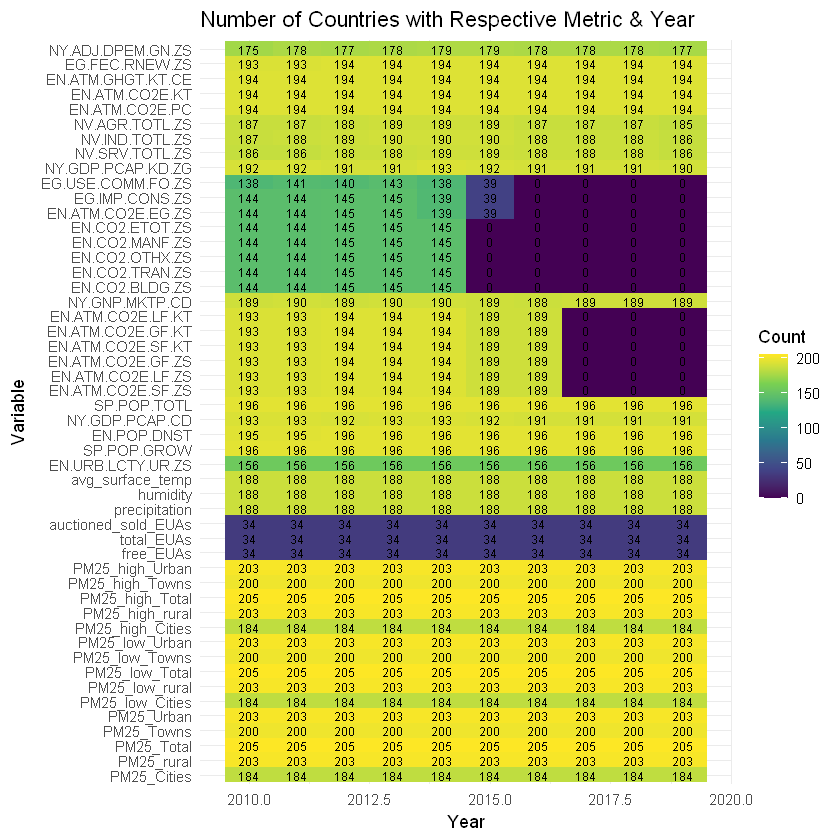

In [251]:

# Calculate the number of non-NA values for each column
non_na_counts <- df %>%
  select(-c(country,country_code)) %>%
  group_by(year) %>%
  summarize(across(everything(), ~sum(!is.na(.))))

# Reshape the data for plotting while retaining column order
non_na_counts_long <- non_na_counts %>%
  pivot_longer(cols = -year, names_to = "variable", values_to = "count") %>%
  mutate(variable = factor(variable, levels = colnames(df)[-1]))  # Exclude the "year" column from levels

# Create the heatmap
heatmap_plot <- ggplot(data = non_na_counts_long, aes(x = year, y = variable, fill = count)) +
  geom_tile() +
  scale_fill_viridis_c() +  # Choose color palette
  geom_text(aes(label = ifelse(is.na(count), "", count)), size = 2.5, color = "black") +  # Add text labels with small font
  labs(title = "Number of Countries with Respective Metric & Year",
       x = "Year",
       y = "Variable",
       fill = "Count") +
  theme_minimal()
# Display the heatmap
print(heatmap_plot)

In [252]:
  # Select unique combinations of "country" and "country_code" from pm25_final
  pm25_unique <- pm25_final_mapped %>%
    select(country) %>%
    unique()

  pm25_unique$pm <- 1

  # Select unique combinations of "country" and "country_code" from eu_ets_final
  eu_ets_unique <- eu_ets_final_mapped %>%
    select(country) %>%
    unique()

  eu_ets_unique$euets <- 1

  # Select unique combinations of "country" and "country_code" from weather_final
  weather_unique <- weather_final_mapped %>%
    select(country) %>%
    unique()

  weather_unique$weather <- 1

  # Select unique combinations of "country" and "country_code" from wb_indicators_final
  wb_indicators_unique <- wb_indicators_final_mapped %>%
    select(country) %>%
    unique()

  wb_indicators_unique$wb <- 1

# Union the datasets
unioned_dimensions <- bind_rows(pm25_unique, eu_ets_unique, weather_unique, wb_indicators_unique)

# Add origin indicators to each dataset
pm25_unique$pm <- 1
eu_ets_unique$euets <- 1
weather_unique$weather <- 1
wb_indicators_unique$wb <- 1

# Perform full joins
joined_df <- full_join(pm25_unique, eu_ets_unique, by = "country") %>%
             full_join(weather_unique, by = "country") %>%
             full_join(wb_indicators_unique, by = "country")

joined_df[is.na(joined_df)] <- 0

joined_df$total = joined_df$pm + joined_df$euets + joined_df$weather + joined_df$wb

joined_df <- joined_df %>% arrange (pm, total)

joined_df[joined_df$total < 3,]


country,pm,euets,weather,wb,total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NER 300 auctions,0,1,0,0,1
Congo Brazzaville,0,0,1,0,1
FInland,0,0,1,0,1
Jersey,0,0,1,0,1
Palestine,0,0,1,0,1
South Korea,0,0,1,0,1
Svalbard and Jan Mayen,0,0,1,0,1
Turks & Caicos Islands,0,0,1,0,1
Vatican City,0,0,1,0,1
